# Quantum and classical neural networks for Max-Cut (DRAFT)


- toc: true 
- badges: false
- comments: false
- categories: [gnn, qnn]
- author: Sergei Tsimbalist
- use_math: true

In [2]:
#hide

import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

import warnings
warnings.filterwarnings("ignore")

import networkx as nx

import pandas as pd

from plotnine import *
from plotnine.data import *

from qutip import Bloch

# Introduction

Both deep learning and quantum computing have been making the headlines in the recent past - these two topics are seen as "the big things" in computer science. But while deep learning has already delivered a lot, and the question here is: "how far can we go?", the field of quantum computing is still waiting for its quantum-capable hardware - there is a lot more theory in the field describing algorithms that could do cool things, that are otherwise difficult for classical computers.    

At the intersection of machine learning and quantum computing, there exists the field of quantum machine learning, which encompasses two main goals: analyzing quantum data (physics experiments, etc...) and implementing machine learning on quantum hardware. Recently, there has been as increasing research into the quantum analogue of neural networks - parameterized quantum cirquits, which are also called quantum neural networks. Unfortunately, at the present moment it does not seem that quantum neural networks can be of use for classical deep learning problems, their main application is for data that could have some quantum properties. One of the very few exceptions to this that I have found is the maximum cut graph problem.


## MaxCut problem

The problem of maximum cut can be stated as follows: we want to find set of nodes $S$ such that the number or the weight of all edges coming from $S$ to $\overline{S}$, which specifies the cut $S:\overline{S}$, is maximal.  

Below is a random cut of a 10-node graph: yellow and purple nodes belong to different cut partitions, red edges define the cut.

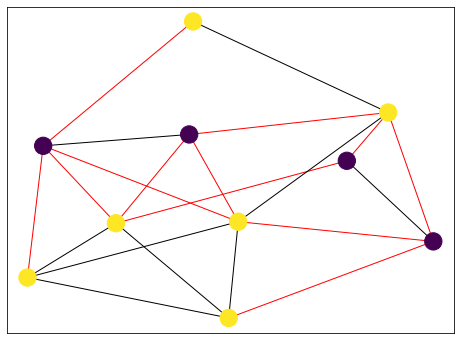

In [7]:
#collapse-hide

def draw_cut(graph, cut):
    ncolors = []
    for n in graph.nodes:
        if n in cut:
            ncolors.append(0)
        else: 
            ncolors.append(1)
    ecolors = []
    for e in graph.edges:
        if (e[0] in cut and e[1] not in cut) or (e[0] not in cut and e[1] in cut):
            ecolors.append('red')
        else: 
            ecolors.append('black')
    fig, ax = plt.subplots(1, 1, figsize=(8, 6));
    nx.draw_networkx(graph, ax=ax, node_color=ncolors, edge_color=ecolors, with_labels=False)
    
ex_graph = nx.erdos_renyi_graph(n=10,p=0.5)
draw_cut(ex_graph, [0,3,7,9])

This problem is interesting for this study as it is NP-hard - there is exact no polynomial time algorithm for it. The practical applications where this problem is used inlude network design and theoretical physics. As it turns out, this problem can be also stated in the terms of physics - the so called Ising model - which then can be neatly mapped to a quantum circuit.

## Graph Neural Networks

Even at the first glance, the naive apprach from supervised deep learning - using graph matrix as input and maximum cuts as output, should not work: firstly, there can be many maximum-cuts, finding them for large graphs is a problem on itself, and a simple neural network will not exploit the relational properties between the nodes, which is important for a graph.    

In order to exploit the relational structure of a graph, different methods are known: one can employ techniques from convolutional neural networks or recurrent neural networks. Additionally, for each node (or edge) we want to create some informative embedding. 

The image below demonstrates an idea behind graph (convolutional) networks - we look at each node and their neighbours using shared parameters, similarly to how convolution filters works in CNNs. 

![](https://tkipf.github.io/graph-convolutional-networks/images/gcn_web.png "Source: Thomas Kipf https://tkipf.github.io/graph-convolutional-networks" )


If you want to know more, you can watch this video for the introduction to the topic.
> youtube: https://youtu.be/zCEYiCxrL_0



## Quantum Computing



Below is an image of a Block sphere. If we take the upwards direction as qubit zero (or ket zero $|0\rangle$, as quantum scientists call it) and downwards as ket one $|1\rangle$, then a qubit can be anything on the surphace of this unit sphere, for example the green arrow represents a qubit that is in some superposition of $|0\rangle$ and $|1\rangle$. However, we cannot access the state of a qubit directly, instead we would need to perform a measurement operation, that would give us either zero or one in a classical bit.

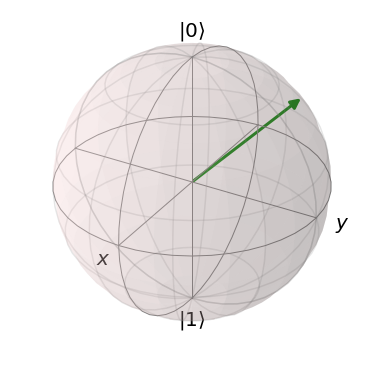

In [10]:
#collapse-hide

bloch_sphere = Bloch()
bloch_sphere.add_vectors([-1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)])
bloch_sphere.show()
bloch_sphere.clear()

A quantum circuit is normally represented as this: there are $n$ qubits, in this case 3, each having their own line, you can apply gates on one or more qubits. Usually at the end of the circuit you perform a measurement and get 3 classical bits of information. Running the circuit multiple times and averaring you can get an estimate of the output value, which is as a rule probabilistic.

The example below is a random 3 qubit circuit composed of:
* $Rx$ - rotation about the x axis (check Bloch sphere above)
* $Ry$ - rotation about the y axis
* $H$ - Hadamard - a superposition gate
* $cX$ gate - controlled NOT gate

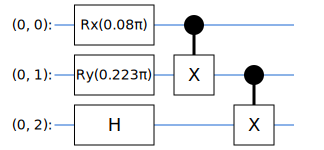

In [11]:
#collapse-hide

q0, q1, q2 = cirq.GridQubit.rect(1, 3)

circuit = cirq.Circuit(
    (
        cirq.rx(0.5).on(q0))**0.5,
    cirq.ry(0.7).on(q1), 
    cirq.CNOT(control=q0, target=q1), 
    cirq.H(q2),cirq.CNOT(control=q1, target=q2))

SVGCircuit(circuit)

### Quantum Neural Networks 

As mentioned previously, a quantum neural network is nothing more than a parameterized quantum circuit.

The image below is of the same quantum circuit, but now it is parameterized by two variables $a, b$ - in essence this is a quantum neural network, you could learn these parameters with respect to some desired output.

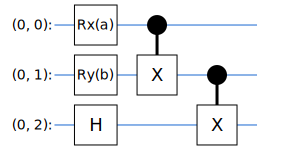

In [12]:
#collapse-hide

q0, q1, q2 = cirq.GridQubit.rect(1, 3)
a, b = sympy.symbols('a b')

circuit = cirq.Circuit(
    (
        cirq.rx(a).on(q0)),
    cirq.ry(b).on(q1), 
    cirq.CNOT(control=q0, target=q1), 
    cirq.H(q2),cirq.CNOT(control=q1, target=q2))

SVGCircuit(circuit)

To get a popular introduction to the topic of Quantum Machine Learning, you can watch this video from Tensorflow Dev Summit: 

> youtube: https://youtu.be/-o9AhIz1uvo


In general, quantum and classical neural networks can be combined in many different ways, depending on our goals. This scheme from Google demonstrates a hybrid quantum-classical neural network and its basic functionality.

![](https://1.bp.blogspot.com/-GrKeW5muOdo/XmKfETB0-AI/AAAAAAAAFZw/qct9L-0QI2kMOsuB1i75exhAyGLYOCaMwCLcBGAsYHQ/s1600/image2.png "Quantum-classical neural network. Source: https://ai.googleblog.com/2020/03/announcing-tensorflow-quantum-open.html")

Quantum neural networks used here will be explored below, under the Methods section.

# Methods



## Graph NN for MaxCut

For the graph neural network I will use implementation provided by this paper <a href="https://arxiv.org/abs/1908.05767">Experimental performance of graph neural networks on random instances of max-cut</a>, as this was actually the only working implementation that I have found. You can consult the paper for the details of the model.

## Quantum NN for MaxCut

For the quantum model I will use implementation provided in <a href="https://arxiv.org/pdf/2003.02989.pdf">Tensorflow Quantum</a>, check chapter IV.C for details in the referenced paper. 





## Meta learning QNN

Main drawback of the previous model is that it is optimized for one concrete graph. For this reason the same paper proposes in chapter V.A a meta-learning framework for the QNN. The idea is to use a recurrent neural network to learn the parameter updates based on previous parameter values and the error signal. This model should be able to generalize to different graphs and even graph sizes. 


## Experiments

Relatively small graphs will be used(10 and 20 nodes), because as it turned out my hardware cannot handle quantum tensorflow models for bigger graphs. On the positive side, during test phase its possible to search over all possible cuts of which there are $2^n$ ($n$ number of nodes) to find the optimum and report the achieved ratio of that optimum. The accuracy of the model will then be averaged ratio of optimum over all test samples. 


### Generating random graphs

Graphs for training and testing will be generated using an <a href="https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model">Erdos-Renyi</a> random graph model with different parameters, to see if the graph structure has any effect on the performance. 


 

Erdos-renyi random graph with p=0.7


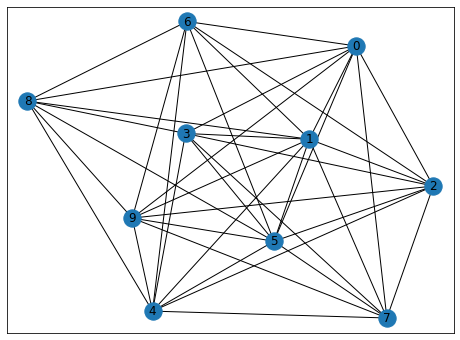

In [41]:
#hide-input

graph = nx.erdos_renyi_graph(n=10,p=0.7)
print('Erdos-renyi random graph with p=0.7')
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(graph, ax=ax)

Erdos-renyi random graph with p=0.3


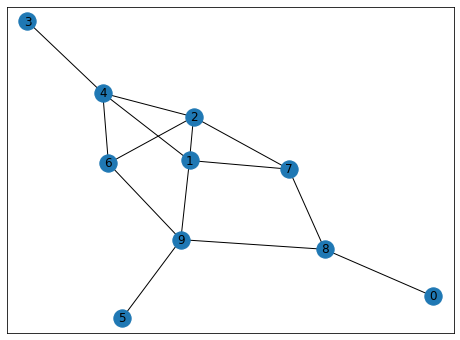

In [42]:
#hide-input

graph = nx.erdos_renyi_graph(n=10,p=0.3)
print('Erdos-renyi random graph with p=0.3')
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(graph, ax=ax)

# Results



## QNN vs GNN 

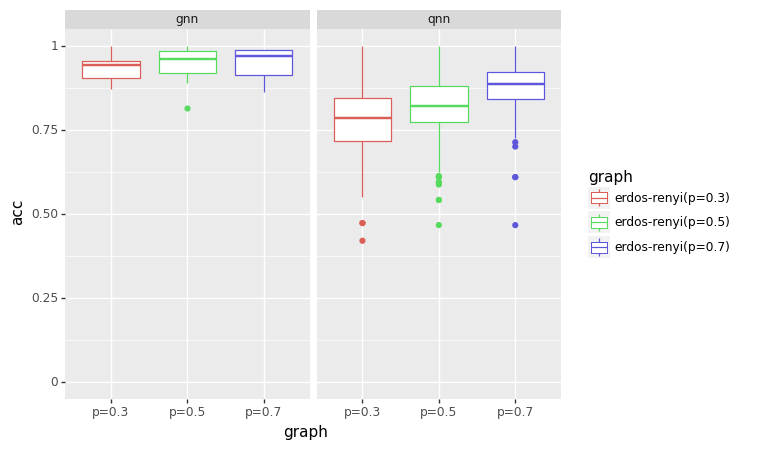

<ggplot: (-9223371860222759196)>

In [52]:
#hide_input

df = pd.read_csv('exp1.csv')


p = ggplot(df, aes( y='acc', x='graph', color='graph'))+ geom_boxplot() + ylim([0,1]) + facet_wrap('model') + scale_x_discrete(labels=['p=0.3','p=0.5','p=0.7'])
p

Interestingly, both models give better predictions for higher p parameter values, meaning for the graphs with more edges in general. 

## Meta-learning QNN vs GNN

# Conclusion

These results should be taken in the context that practical quantum computers are still far away and all experiments of this sort are done in simulators...


Publication of this post has benefitted from the scholarship provided by IT academy http://studyitin.ee 
![](https://www.cs.ut.ee/sites/default/files/styles/ut_content_width/public/ita_small-logo-black-eng.png?itok=NnmpOIOy)

# References

https://arxiv.org/abs/1908.05767

https://arxiv.org/pdf/2003.02989.pdf

https://github.com/tensorflow/quantum/blob/research/metalearning_qaoa/metalearning_qaoa.ipynb

https://github.com/tensorflow/quantum/blob/research/qaoa/qaoa.ipynb

https://github.com/ElainaYao/maxCut